## Training Notebook

### 1] Data preparation
List and read *.wav* to generate training dataset. The features are extracted with **librosa**, and aim to be simple to be able to be extracted at run time on the RasPi. The feature are extracted on a window of 1sec, and to augment the data, we use a sliding windows of 300ms. Then the dataframe is save as csv, and we prepare training vector.

### 2] Model definition
In order to be able to run the model on the RaspPi, we only use a simple NN model.

### 3] Training - Saving - tf-lite convertion
Small training, and simple convertion to tf-lite model (no quantization)

### 4] Possible improvement
- Collect more data
- More complexe features
- More complexe model

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os, glob

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from keras import layers
from keras.models import Sequential
import keras

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get all training file:
## Path init
data_path = "../Data/"
cat_list = [ name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name)) ]
train_dict = {}

## Arbitrary cat dictionnary (should be automated)
cat_index = {}
cat_index["armed"] = 1
cat_index["background"] = 0

## Iter over path
for cat in cat_list:
    wav_file_list = glob.glob(data_path + cat + '/*.wav')
    train_dict[cat] = wav_file_list
    print("{} [{}] : {} files".format(cat, cat_index[cat], len(train_dict[cat])))


armed [1] : 20 files
background [0] : 21 files


In [3]:
# Utilities functions
def get_wav_info(file_name):
    """
    Read out .Wav file, and return signal and sample rate.
    """
    x, sample_rate = librosa.load(file_name)
    return x, sample_rate

def simple_feature_extraction(x, FFT_SIZE=256):
    """
    Extract magnitude from signal (faster to extract on PI)
    """
    mfccs = librosa.stft(librosa.util.normalize(x), n_fft=FFT_SIZE, window='hamming')
    #mfccs = np.abs(D)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    return(mfccsscaled)

def sliding_window_sound(data, sample_rate, w_size_ms, stepsize_ms=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a sound signal. input in [ms]
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize_ms < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    # Convert time to sample ([ms] -> sample)
    size = int( (sample_rate * w_size_ms) / 1000)
    stepsize = int( (sample_rate * stepsize_ms) / 1000)

    # Generate Windows:
    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

Armed: Sample rate: 22050 | 108544
Background: Sample rate: 22050 | 131072


[Text(0.5, 15.0, 'time')]

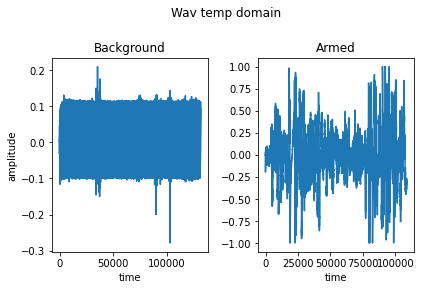

In [4]:
# Simple visualization
# Load file
armed_sample = train_dict["armed"][0]
background_sample = train_dict["background"][0]
armed_samples, armed_sample_rate = get_wav_info(armed_sample)
print("Armed: Sample rate: {} | {}".format(armed_sample_rate, len(armed_samples)))

back_samples, back_sample_rate = get_wav_info(background_sample)
print("Background: Sample rate: {} | {}".format(back_sample_rate, len(back_samples)))

# Plot the wav
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Wav temp domain')
fig.tight_layout(pad=2.0)

ax1.plot(back_samples)
ax1.set_title('Background')
ax1.set(xlabel='time', ylabel='amplitude')

ax2.plot(armed_samples)
ax2.set_title('Armed')
ax2.set(xlabel='time')


In [5]:
# Generate dataframe
column_names = ["orig_file", "cat", "cat_num", "magnitude"]
signal_df = pd.DataFrame(columns = column_names)

## Generate feature for each signal and frame
feat_list = []
for cat in cat_list:
    for wav_file in train_dict[cat]:
        print("Processing {} - {}".format(cat, wav_file))
        
        # Load file
        x, sample_rate = get_wav_info(wav_file)
        
        # Extract windows
        windows = sliding_window_sound(x, sample_rate, 1000, 200)
        
        # Extract feature - Not optimized -
        for window in windows:
            feat_list.append({"orig_file":wav_file, 
                               "cat":cat,
                               "cat_num":cat_index[cat], 
                               "magnitude":simple_feature_extraction(window)})
            
# Generate the dataframe
signal_df = signal_df.append(feat_list)

# Easy data exploration
print(signal_df.shape)
signal_df.head()

Processing armed - ../Data/armed/3.wav
Processing armed - ../Data/armed/2.wav
Processing armed - ../Data/armed/15.wav
Processing armed - ../Data/armed/1.wav
Processing armed - ../Data/armed/18.wav
Processing armed - ../Data/armed/20.wav
Processing armed - ../Data/armed/17.wav
Processing armed - ../Data/armed/12.wav
Processing armed - ../Data/armed/9.wav
Processing armed - ../Data/armed/8.wav
Processing armed - ../Data/armed/7.wav
Processing armed - ../Data/armed/14.wav
Processing armed - ../Data/armed/5.wav
Processing armed - ../Data/armed/16.wav
Processing armed - ../Data/armed/13.wav
Processing armed - ../Data/armed/11.wav
Processing armed - ../Data/armed/10.wav
Processing armed - ../Data/armed/6.wav
Processing armed - ../Data/armed/19.wav
Processing armed - ../Data/armed/4.wav
Processing background - ../Data/background/3.wav
Processing background - ../Data/background/2.wav
Processing background - ../Data/background/15.wav
Processing background - ../Data/background/1.wav
Processing b

,orig_file,cat,cat_num,magnitude
0,../Data/armed/3.wav,armed,1,"[(-0.70649153+0j), (0.3045584+0.080432296j), (..."
1,../Data/armed/3.wav,armed,1,"[(0.38909912+0j), (-0.1704741-0.024563044j), (..."
2,../Data/armed/3.wav,armed,1,"[(0.5507703+0j), (-0.23985884-0.040042985j), (..."
3,../Data/armed/3.wav,armed,1,"[(0.13520396+0j), (-0.053749308+0.023851296j),..."
4,../Data/armed/3.wav,armed,1,"[(1.7767248+0j), (-0.75116485+0.1269502j), (-0..."


In [6]:
# Save to .csv
signal_df.to_csv("training_set.csv", index = False)

# Read directly from csv (some issue with np.array as columns)
"""
def converter(instr):
    # Datasave np.array as string, so need to convert back
    return np.fromstring(instr[1:-1],sep=' ')

dataset_path = "training_set.csv"
train_df = pd.read_csv(dataset_path, converters={'Vec':converter})
train_df.head()
"""

In [7]:
# Extract label and feature
X = np.array(signal_df.magnitude.tolist())
y = np.array(signal_df.cat_num.tolist())

print("X_shape: {} | Y_shape: {}".format(X.shape, y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_shape: (845, 129) | Y_shape: (845,)


In [8]:
# 2] Build simple model
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33280     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 74,562
Trainable params: 74,562
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 3] train
classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
5/5 [==============================] - 0s 1ms/step - loss: 0.6657 - accuracy: 0.6509
Epoch 2/100
5/5 [==============================] - 0s 961us/step - loss: 0.6089 - accuracy: 0.8325
Epoch 3/100
5/5 [==============================] - 0s 953us/step - loss: 0.5609 - accuracy: 0.8562
Epoch 4/100
5/5 [==============================] - 0s 1ms/step - loss: 0.5162 - accuracy: 0.8594
Epoch 5/100
5/5 [==============================] - 0s 796us/step - loss: 0.4722 - accuracy: 0.8468
Epoch 6/100
5/5 [==============================] - 0s 752us/step - loss: 0.4367 - accuracy: 0.8357
Epoch 7/100
5/5 [==============================] - 0s 996us/step - loss: 0.4121 - accuracy: 0.8452
Epoch 8/100
5/5 [==============================] - 0s 747us/step - loss: 0.3934 - accuracy: 0.8515
Epoch 9/100
5/5 [==============================] - 0s 767us/step - loss: 0.3767 - accuracy: 0.8531
Epoch 10/100
5/5 [==============================] - 0s 797us/step - loss: 0.3728 - accuracy: 0.8594
Epoch 11/100


5/5 [==============================] - 0s 822us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 84/100
5/5 [==============================] - 0s 683us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 85/100
5/5 [==============================] - 0s 885us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 86/100
5/5 [==============================] - 0s 750us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 87/100
5/5 [==============================] - 0s 712us/step - loss: 0.0056 - accuracy: 1.0000
Epoch 88/100
5/5 [==============================] - 0s 842us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 89/100
5/5 [==============================] - 0s 687us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 90/100
5/5 [==============================] - 0s 683us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 91/100
5/5 [==============================] - 0s 823us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 92/100
5/5 [==============================] - 0s 705us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 93/100


In [10]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.8962264060974121


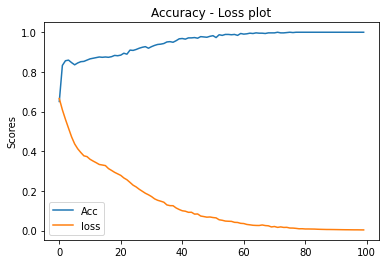

In [11]:
# Training Plot
p1 = plt.plot(classifier.history['accuracy'])
p2 = plt.plot(classifier.history['loss'])
plt.ylabel('Scores')
plt.title('Accuracy - Loss plot')
plt.legend((p1[0], p2[0]), ('Acc', 'loss'))

In [12]:
# Save Keras model:
model.save('simple_feature_test.h5')

In [13]:
# Convert to TFlite model [without quantization]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("dev_model.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpo__ul3es/assets


300296

**Now we can try to do some inference on the RasPi :D**